# NY Parking Violation Data Analysis

## Problem

* Exploratory data analysis of **NYC Parking violation** data for **2017** – **2021** years (5 years)
* Infer from the data analysis findings

> **Dataset** : https://data.cityofnewyork.us/City-Government/Parking-Violations-Issued-Fiscal-Year-2022/pvqr-7yc4

## Environment

* Python 3
* Spark 3.0 (colab) / 3.1 (local)
* Spark Data Frames & Spark SQL
* Local & Google Colab

## Dataset Details

Dataset contains New York city Police Department issued parking violations details

### Raw Dataset details
- Fiscal year data (July 1 - June 30) is available. That means one file contains data for 2 years
- All years data has same 43 columns
- Total Number of records: 65449427
- Total size: 11.2 GB

### Processed Data details
- Removed 30 columns which are not used in our analysis (Most of the removed columns don't have data for > 50% records)
- Total Columns: 13
- Total Number of records: 60076484
- Total Size: 4.6 GB

### Columns Summary

| S. No. | Source   Column Name    | Description/Comment                                  |
|--------|-------------------------|------------------------------------------------------|
| 1      | SUMMONS NUMBER          | UNIQUE IDENTIFIER OF SUMMONS                         |
| 2      | PLATE ID                | REGISTERED PLATE ID                                  |
| 3      | REGISTRATION STATE      | STATE OF PLATE   REGISTRATION                        |
| 4      | PLATE TYPE              | TYPE OF PLATE                                        |
| 5      | ISSUE DATE              | ISSUE DATE                                           |
| 6      | VIOLATION CODE          | TYPE OF   VIOLATION                                  |
| 7      | VEHICLE BODY TYPE       | VEHICLE BODY TYPE   WRITTEN ON SUMMONS (SEDAN, ETC.) |
| 8      | VEHICLE MAKE            | MAKE OF CAR WRITTEN ON SUMMONS                       |
| 9      | VIOLATION PRECINCT      | POLICE STATION OF VIOLATION                          |
| 10     | ISSUER PRECINCT         | PRECINCT OF ISSUANCE                                 |
| 11     | VIOLATION TIME          | VIOLATION TIME                                       |
| 12     | VEHICLE COLOR           | CAR COLOR WRITTEN ON   SUMMONS                       |
| 13     | VIOLATION   DESCRIPTION | DESCRIPTION OF   VIOLATION                           |

### Columns Details

#### Plate Type

Registration Class Codes for vehicles. 3 letters code

Common Plate types are 
* Passenger Vehicles (PAS): standard issue plates
* Commercial Vehicles (COM): Full-size vans and most pickups
* Medallion (OMT): Taxis
* Personalized Plates (SRF): cars, mini-vans, SUVs and some pick-ups registered as passenger class
* Special Omnibus Rentals (OMS)

https://dmv.ny.gov/registration/registration-class-codes

#### Violation Code
Type of violation. Codes are from 1-99. Fines are charged based on this

Some of the common violation codes & their fines

| Violation Code | Description                      | Fine |
|----------------|----------------------------------|------|
| 36             | PHTO SCHOOL ZN SPEED VIOLATION   | 50   |
| 21             | NO   PARKING-STREET CLEANING     | 45   |
| 38             | FAIL   TO DSPLY MUNI METER RECPT | 35   |
| 14             | NO   STANDING-DAY/TIME LIMITS    | 115  |
| 20             | NO   PARKING-DAY/TIME LIMITS     | 60   |

https://data.cityofnewyork.us/api/views/pvqr-7yc4/files/7875fa68-3a29-4825-9dfb-63ef30576f9e?download=true&filename=ParkingViolationCodes_January2020.xlsx

#### Vehicle Body Type

Common Vehicle body types are 
* suburban(SUBN): Vehicle that can be used to carry passengers and cargo
* four-door sedan (4DSD)
* Van Truck (VAN
* Delivery Truck (DELV)
* Pick-up Truck (PICK)
* two-door sedan (2DSD) 
* Sedan (SEDN)

https://nysdmv.custhelp.com/app/answers/detail/a_id/491/kw/body%20type%20subn

#### Vehicle Make

The DMV code for the make of a vehicle that appears on the registration. The DMV make code is the first 5 letters of the vehicle’s make name. If the vehicle make is more than one word, the make code is the first 2 letters of the first two words with a slash in between

Common Vehicle Makes are 
* Honda (HONDA)
* Toyota (TOYOT)
* Ford (FORD)
* Nissan (NISSA)
* Chevrolet (CHEVR)
* mercedes benz (ME/BE)

https://data.ny.gov/Transportation/Vehicle-Makes-and-Body-Types-Most-Popular-in-New-Y/3pxy-wy2i
https://data.ny.gov/api/assets/83055271-29A6-4ED4-9374-E159F30DB5AE

#### Vehicle Colors

Common colors are
* Gray (GY)
* White (WH)
* Black (BK)
* Blue (BL)
* Red (RD)

## Config

In [36]:
# Execution environment. Use False for local execution
colab_env = False
drive_path = "/content/drive/MyDrive/Project/data_eng_at_scale" # Project home

# Use Sample file for speedy execution
processed_file = True

# Set to full-sanitized-data.csv for full sanitized file (4.6 GB)
processed_file_path = f'{drive_path}/data/sample-100000.csv' if colab_env else "../data/sample-100000.csv"

# Specify the raw CSV files path
raw_CSV_path = f'{drive_path}/data/Parking_*.csv' if colab_env else "../data/Parking*.csv"

csv_files = processed_file_path if processed_file else raw_CSV_path

# For faster execution. Some statements are skipped based on this check
presenting = False

# Specify the years for which we are reading the data from CSV
years = [2017, 2018, 2019, 2020, 2021]

# Schema Types. Only specify for the non-string type & NULL columns. Others  are considered as string
schema_types = {
  "Summons Number": {"type": "long", "null": False},
  "Issue Date"    : {"type": "date" if processed_file else "string", "null": True}, 
  "Violation Code": {"type": "integer", "null": True},
  "Violation Precinct": {"type": "integer", "null": True},
  "Issuer Precinct": {"type": "integer", "null": True},
}

# Columns which are used in the analysis. Other columns will be removed
used_columns = ["Summons Number", "Plate ID", "Registration State", "Plate Type", "Issue Date", "Violation Code", "Vehicle Body Type", "Vehicle Make", "Violation Precinct", "Issuer Precinct", "Violation Time", "Vehicle Color", "Violation Description"]

# All the columns which are there in the datset (Need to be in CSV file order)
schema_columns = ["Summons Number", "Plate ID", "Registration State", "Plate Type", "Issue Date", "Violation Code", "Vehicle Body Type", "Vehicle Make", "Issuing Agency", "Street Code1", "Street Code2", "Street Code3", "Vehicle Expiration Date", "Violation Location", "Violation Precinct", "Issuer Precinct", "Issuer Code", "Issuer Command", "Issuer Squad", "Violation Time", "Time First Observed", "Violation County", "Violation In Front Of Or Opposite", "House Number", "Street Name", "Intersecting Street", "Date First Observed", "Law Section", "Sub Division", "Violation Legal Code", "Days Parking In Effect    ", "From Hours In Effect", "To Hours In Effect", "Vehicle Color", "Unregistered Vehicle?", "Vehicle Year", "Meter Number", "Feet From Curb", "Violation Post Code", "Violation Description", "No Standing or Stopping Violation", "Hydrant Violation", "Double Parking Violation"] if not processed_file else [i.lower().replace(" ", '_') for i in used_columns]

# Generates the sample CSV 
if not processed_file:
  sample_CSV_generate = False # Generate the sample CSV
  sample_CSV_records = 100000 # No. of records to write into the sample CSV file
  sample_CSV_path = f"{drive_path}/data/sample-{sample_CSV_records}.csv" if colab_env else f"../data/sample-{sample_CSV_records}.csv" # path to save
  sample_seed = sample_CSV_records # Seed value so that we get same random records

## Setup

### Spark Setup

In [37]:
# For google Colab
if colab_env:
  !apt-get install openjdk-8-jdk-headless -qq > /dev/null
  !wget -q https://mirrors.estointernet.in/apache/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz -P /content/
  !tar xf /content/drive/Shareddrives/DA231-2021-Aug-Public/spark-3.0.3-bin-hadoop2.7.tgz
  !pip install -q findspark
  import os
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"

### Imports

In [38]:
# Reload all changed modules every time before executing a new line
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
# PySpark related
import findspark
findspark.init()
findspark.find()

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col # Frequently using this. hence imported separately

# user defined modules import
import data_preprocess as dp
import basic_analysis as ba
import precinct_based_analysis as pba
import time_based_analysis as tba
import season_based_analysis as sba
import revenue_based_analysis as rba
import mis_analysis as ma

### Spark Session

In [40]:
spark = (
          SparkSession
            .builder
            .master("local[*]") # Using all available cores
            .appName("NYC Parking Violation Analysis")
            .getOrCreate()
        )
spark

## Data Pre-processing

### Reading CSV files into DataFrame

In [41]:
# Better performance than inferSchema=True
NY_schema = dp.get_schema(schema_columns, schema_types)

org_df = spark.read.option("header", True).schema(NY_schema).csv(csv_files)

In [42]:
if not processed_file:
  print(f'Shape : {(org_df.count(), len(org_df.columns))}')
  org_df.printSchema()
  org_df.show(2)

In [43]:
if not processed_file:
  presenting and org_df.summary().toPandas().transpose() # More execution time

### Pre-processing

In [44]:
# No pre-processing while using Sample file
df = org_df
if not processed_file:
  # Need this setting to process the legacy time formats like 07/16/2019 12:00:00 AM 
  spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

  # Remove 30 unused columns
  df = dp.remove_unused_columns(df, used_columns)

  # Removes duplicate rows. Also drops the rows which are having null in all the columns
  df = dp.drop_duplicates_nulls(df) 

  # Converting column names to lower case & replacing spaces with _
  df = dp.santize_column_names(df)

  # Ensure all the values in 'Summons Number' column are unique
  dp.assert_uniqueness(df, column_name="summons_number")

  # Converting issue date string type to Date type
  df = dp.convert_to_date(df, column_name="issue_date", format="MM/dd/yyyy")

  # Removing the rows which are outside of 2017-2021
  df = dp.remove_outside_years_data(df, years, "issue_date")

## Sample file generation

In [45]:
from pathlib import Path
from shutil import rmtree

def write_CSV(df, CSV_path):
  
  # Creates CSV in a folder. But memory efficient
  df.coalesce(1).write.mode("overwrite").csv(CSV_path, header=True) 

  # OOM
  # df.toPandas().to_csv(CSV_path, index=False)

  # Moving file to data folder
  f_path = list(Path(CSV_path).glob('*.csv'))[0]
  Path(f_path).rename(CSV_path+'.tmp')
  rmtree(CSV_path)
  Path(CSV_path+'.tmp').rename(CSV_path)


In [46]:
if (not processed_file and sample_CSV_generate):
  total_records = df.count()
  fraction = (sample_CSV_records+10000)/total_records # Exact records are not coming. Hence increasing the fraction using 10k
  sample_df = df.sample(fraction=fraction, seed=sample_seed).limit(sample_CSV_records) # Getting exact number of records
  print(f"Sample records: {sample_df.count()}")
  write_CSV(sample_df, sample_CSV_path)
  df = sample_df

## Final DF / Table for Analysis

In [47]:
df.cache() # Cache the data
total_records = df.count() # Materialize the cache
print(f'Shape : {(total_records, len(df.columns))}')
df.printSchema()
df.show(2)

Shape : (100000, 13)
root
 |-- summons_number: string (nullable = true)
 |-- plate_id: string (nullable = true)
 |-- registration_state: string (nullable = true)
 |-- plate_type: string (nullable = true)
 |-- issue_date: string (nullable = true)
 |-- violation_code: string (nullable = true)
 |-- vehicle_body_type: string (nullable = true)
 |-- vehicle_make: string (nullable = true)
 |-- violation_precinct: string (nullable = true)
 |-- issuer_precinct: string (nullable = true)
 |-- violation_time: string (nullable = true)
 |-- vehicle_color: string (nullable = true)
 |-- violation_description: string (nullable = true)

+--------------+--------+------------------+----------+----------+--------------+-----------------+------------+------------------+---------------+--------------+-------------+---------------------+
|summons_number|plate_id|registration_state|plate_type|issue_date|violation_code|vehicle_body_type|vehicle_make|violation_precinct|issuer_precinct|violation_time|vehicle_colo

21/12/11 21:26:36 WARN CacheManager: Asked to cache already cached data.


In [48]:
presenting and df.describe().toPandas().transpose() # More execution time

False

In [49]:
df.createOrReplaceTempView("NYCPV")

## Analysis

### 01 Basic Analysis

#### **How often does each violation code occur? (frequency of violation codes find the top 10) ?** 

**Top violation codes**

Speed violations are more than no parking violations 

| Violation Code | Description                      | Fine |
|----------------|----------------------------------|------|
| 36             | PHTO SCHOOL ZN SPEED VIOLATION   | 50   |
| 21             | NO   PARKING-STREET CLEANING     | 45   |
| 38             | FAIL   TO DSPLY MUNI METER RECPT | 35   |
| 14             | NO   STANDING-DAY/TIME LIMITS    | 115  |
| 20             | NO   PARKING-DAY/TIME LIMITS     | 60   |

,violation_code,no_of_tickets
0,36,20411
1,21,12990
2,38,8901
3,14,7601
4,20,6298
...,...,...
81,65,2
82,59,1
83,92,1
84,3,1


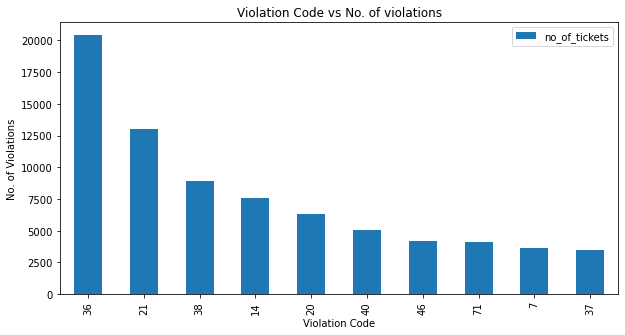

In [50]:
# print('Top5 frequency of violation codes')
ba.violation_frequencey(df)

#### **How often does each vehicle body type get a parking ticket? (find the top 10)**

Passenger vehicles have been getting more violations than commercial vehicles 

Top5 Body type


,vehicle_body_type,Ticket_Frequency
0,SUBN,37586
1,4DSD,27861
2,VAN,12298
3,DELV,4939
4,PICK,2676
...,...,...
181,CML,1
182,DEIV,1
183,12PU,1
184,WVKU,1


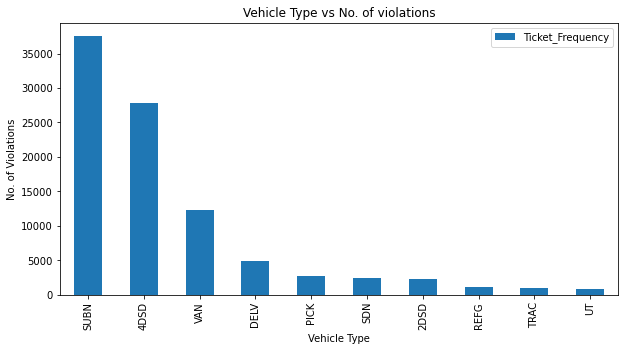

In [51]:
print('Top5 Body type')
ba.violations_by_bodytype(df)

#### **How often does each vehicle make get a parking ticket? (find the top 10)**

Toyota, Ford & Honda vehicles are having more violations

Top5 Vehicle Make


,vehicle_make,Ticket_Frequency
0,TOYOT,10914
1,FORD,10900
2,HONDA,10697
3,NISSA,8894
4,CHEVR,5871
...,...,...
266,CIMC,1
267,CUB C,1
268,BB,1
269,JEY,1


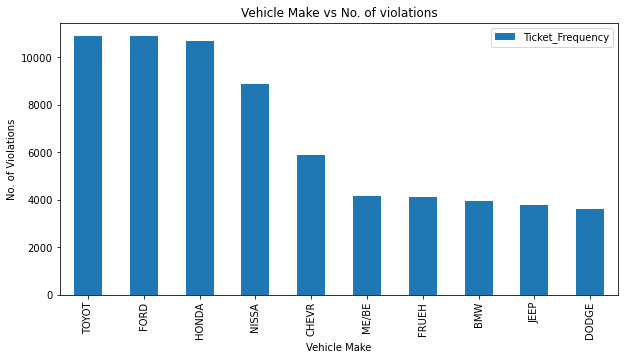

In [52]:

print('Top5 Vehicle Make')
ba.violations_by_make(df)

### 02 Precinct based Analysis

A **precinct** is a police station that has a certain zone of the city under its command

#### **Find the (10 highest) frequencies of violating Precincts (this is the precinct of the zone where the violation occurred)**

,violation_precinct,no_of_violations
0,19,3711
1,14,3056
2,18,2666
3,1,2533
4,114,2497
...,...,...
92,80,1
93,163,1
94,27,1
95,117,1


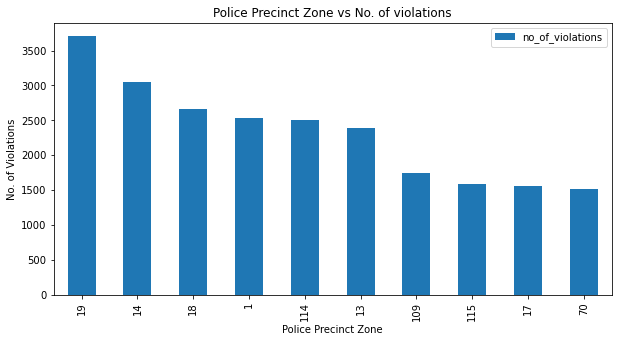

In [53]:
# print('Top 5 Violation precicts')
pba.violating_precicts(df, True)

#### **Find the (10 highest) frequencies of Issuing Precincts (this is the precinct that issued the ticket)**

,issuer_precinct,no_of_violations
0,19,3606
1,14,2938
2,18,2549
3,1,2483
4,114,2445
...,...,...
133,426,1
134,39,1
135,883,1
136,21,1


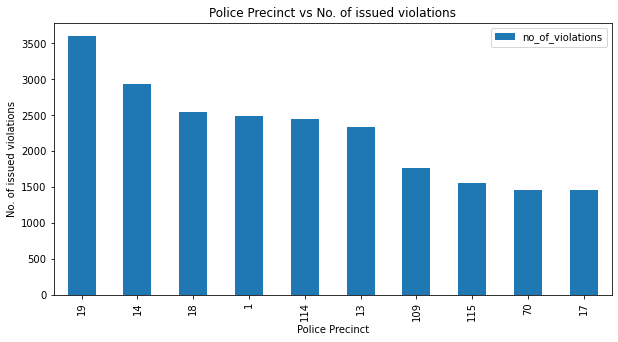

In [54]:
# print('Top 5 Issuer precicts')
pba.issuing_precincts(df, True)

#### **Find the violation code frequency across 3 precincts which have issued the most number of tickets (Top 5)**

Top 3 Violating Precicts : ['19', '14', '18']


,violation_code,Freq of Violations
0,14,1750
1,69,947
2,46,702
3,38,679
4,31,660
5,20,537
6,21,468
7,47,400
8,37,350
9,40,276


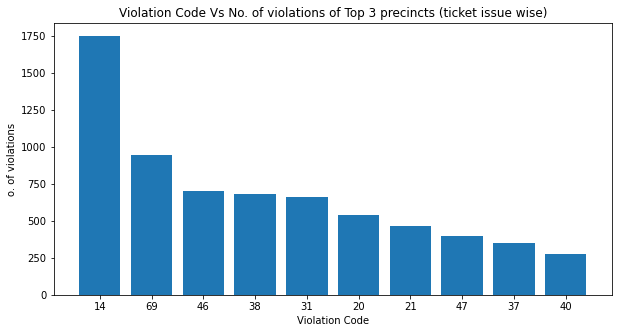

In [55]:
# print('Violation frequencies from top 3 issuer precicts')
pba.violation_code_frequency_top3_precincts(df, True)

### 03 Time based Analysis

#### **Divide 24 hours into 6 equal discrete bins of time. For each of these groups, find the 3 most commonly occurring violations**

In [56]:
# Divide 24 hours into six equal discrete bins of time.
# Bin Time Interval
# 1 12:00 AM to 4:00 AM
# 2 4:00 AM to 8:00 AM
# 3 8:00 AM to 12:00 PM
# 4 12:00 PM to 4:00 PM
# 5 4:00 PM to 8:00 PM
# 6 8:00 PM to 12:00 AM
tba.three_most_common_violations_in_6_time_bins (spark, True)

   violation_time_bin violation_time violation_code  violation_count
0                   1       12AM-4AM             21              465
1                   1       12AM-4AM             40              324
2                   1       12AM-4AM             78              192
   violation_time_bin violation_time violation_code  violation_count
0                   2        4AM-8AM             36             1794
1                   2        4AM-8AM             40             1372
2                   2        4AM-8AM             14             1303
   violation_time_bin violation_time violation_code  violation_count
0                   3       8AM-12PM             21            10244
1                   3       8AM-12PM             36             6133
2                   3       8AM-12PM             38             3087
   violation_time_bin violation_time violation_code  violation_count
0                   4       12PM-4PM             36             6616
1                   4       12PM-4

#### **For the 5 most commonly occurring violation codes, find the most common times of day (in terms of the bins from the previous part)**

  violation_code  violation_time_bin violation_time  voilation_count
0             21                   3       8AM-12PM            10244
1             36                   4       12PM-4PM             6616
2             36                   3       8AM-12PM             6133
3             36                   5        4PM-8PM             4284
4             38                   4       12PM-4PM             4109


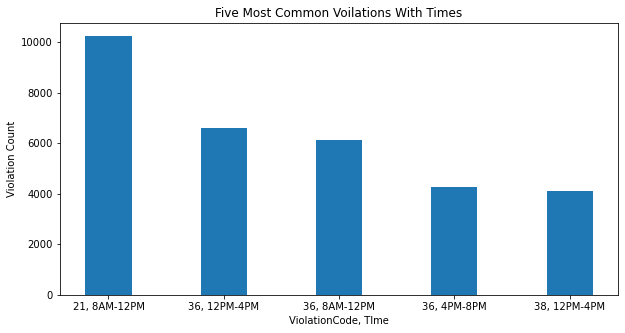

In [57]:
# Divide 24 hours into six equal discrete bins of time.
# Bin Time Interval
# 1 12:00 AM to 4:00 AM
# 2 4:00 AM to 8:00 AM
# 3 8:00 AM to 12:00 PM
# 4 12:00 PM to 4:00 PM
# 5 4:00 PM to 8:00 PM
# 6 8:00 PM to 12:00 AM
tba.five_most_common_Violations_with_times(spark, True)

### 04 Year / Season based Analysis

#### **What is the average reduction in violations for the year 2020 compared to 2019 (due to COVID), and year 2019 compared to 2018**

,Reduction Years,Reduction
0,Reduction 2019 from 2018,-6.878788
1,Reduction 2020 from 2019,-2.306020


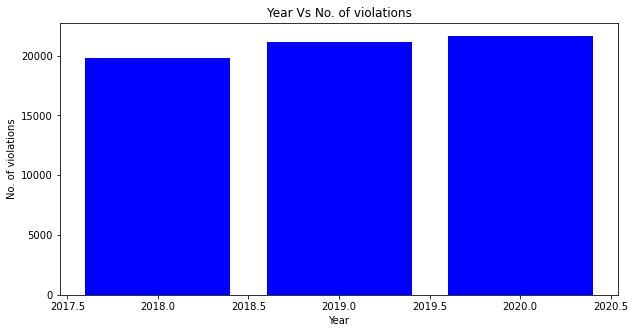

In [58]:
# print("Reduction in violations due to covid")
sba.reduction_in_violations(df)

#### **Divide the year into 3 number of seasons, and find frequencies of tickets for each season**

,season,No of tickets
0,winter,22737
1,summer,27608
2,spring,24636
3,autumn,25019


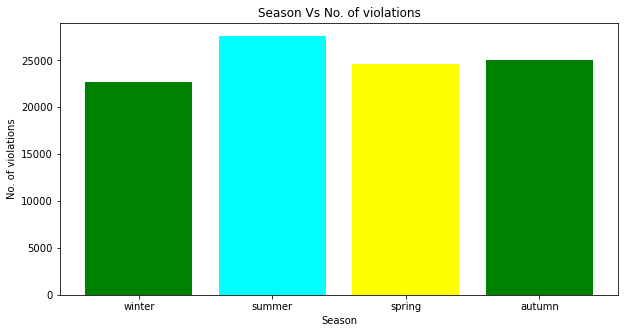

In [59]:
# print("Frequencies of violation in each season")
sba.season_violation_frequencies(df)

#### **Find the 3 most common violations for each of these seasons**

,Violation Code,Frequency,Season
0,36,5372,spring
1,21,3008,spring
2,38,2025,spring
3,36,4024,winter
4,21,2976,winter
5,38,2250,winter
6,36,6132,summer
7,21,3763,summer
8,38,2291,summer
9,36,4883,autumn


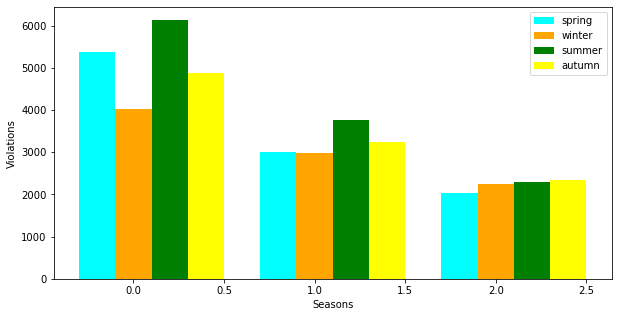

In [60]:
# print("Frequencies of violation in each season")
sba.common_violations_season(df)

### 05 Revenue based Analysis

The fines collected from all the parking violation constitute a revenue source for the NYC police department
Fine amounts for each violation code are listed here https://www1.nyc.gov/site/finance/vehicles/services-violation-codes.page

#### **Find the total amount collected year wise**

* Violation revenue is keep on increasing year on year

,year,revenue
0,2017,9820535
1,2018,10197000
2,2019,10898430
3,2020,11149750
4,2021,9434285


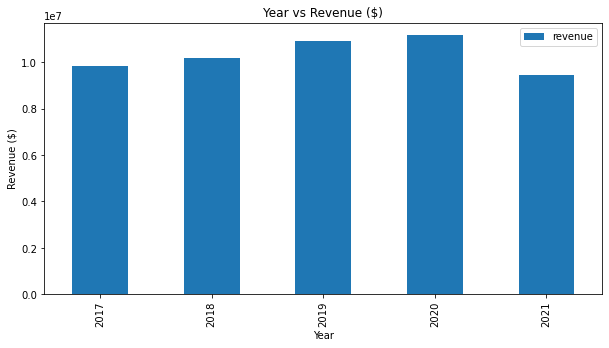

In [61]:
rba.yearly_revenue(df)

#### **Find the top 5 violation codes which collected highest amount**

* Violation revenue is keep on increasing year on year

| Violation Code | Description                      | Fine |
|----------------|----------------------------------|------|
| 36             | PHTO SCHOOL ZN SPEED VIOLATION   | 50   |
| 21             | NO   PARKING-STREET CLEANING     | 45   |
| 38             | FAIL   TO DSPLY MUNI METER RECPT | 35   |
| 14             | NO   STANDING-DAY/TIME LIMITS    | 115  |
| 20             | NO   PARKING-DAY/TIME LIMITS     | 60   |

,violation_code,cost
0,36,10511665
1,21,6689850
2,38,4584015
3,14,3914515
4,20,3243470
...,...,...
75,96,1030
82,59,515
83,92,515
84,3,515


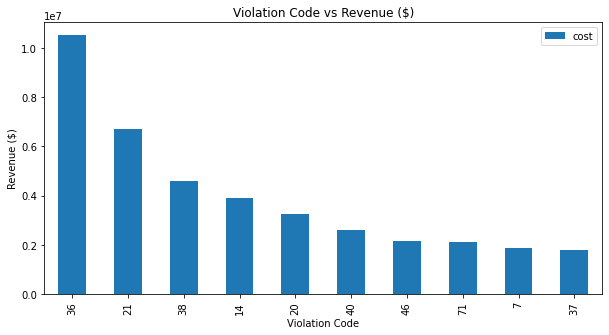

In [62]:
rba.highest_revenue(df)

### 06 Miscellaneous Analysis

#### **Find the top 10 Repeat offenders**

* There is a invalid blank plate ID with more number of violations
* **64638MD** plate has the highest violations - 17

,plate_id,no_of_violations
0,BLANKPLATE,84
1,64638MD,17
2,AT461E,11
3,17744MD,10
4,35810MJ,10
...,...,...
93643,JVG0334,1
93644,HXN2134,1
93645,JNZ1202,1
93646,JDP9633,1


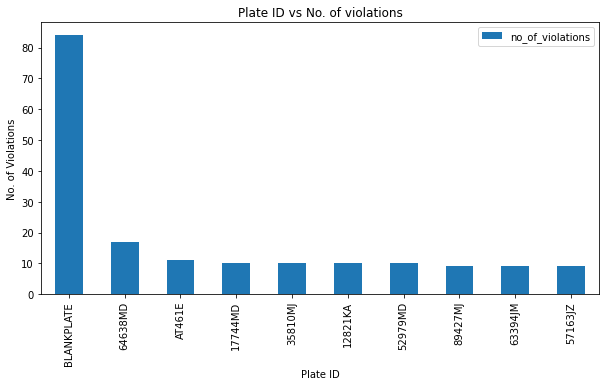

In [63]:
ma.repeat_offenders(spark)

#### **Compare in state violations vs Out of state violations**

* Violations are registered for **68** out of state vehicles. But USA has 50 states. So we might have invalid entires in state column
* **New Jersey** state registered vehicles got highest violations

,registration_state,no_of_violations
0,NY,77102
1,NJ,9045
2,PA,2815
3,FL,1482
4,CT,1372
...,...,...
57,PR,2
58,PE,1
59,NB,1
60,BC,1


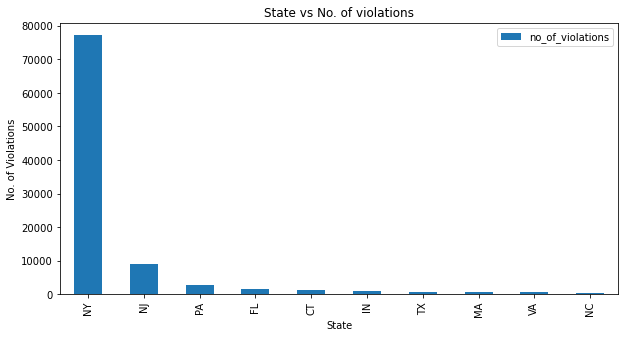

In [64]:
ma.in_out_state(spark)

#### **Find number of violations on weekdays & weekends**

* Weekends violations are ~50% less compared to week days

,week,no_of_violations
0,Thursday,18428
1,Tuesday,18141
2,Friday,18015
3,Wednesday,17418
4,Monday,16237
5,Saturday,8443
6,Sunday,3318


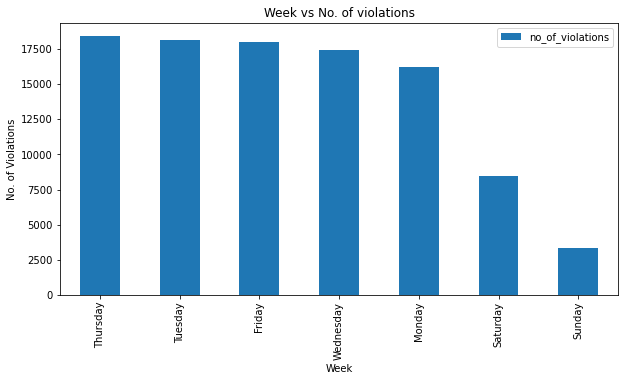

In [65]:
ma.weekends(spark)

#### **Find which days(holidays) has less number of violations**

* Christmas & New year holidays registered less number of violations

,day,no_of_violations
0,25-12,16
1,1-1,24
2,29-2,40
3,4-7,44
4,17-12,131
...,...,...
361,12-3,386
362,6-8,387
363,9-3,395
364,20-8,395


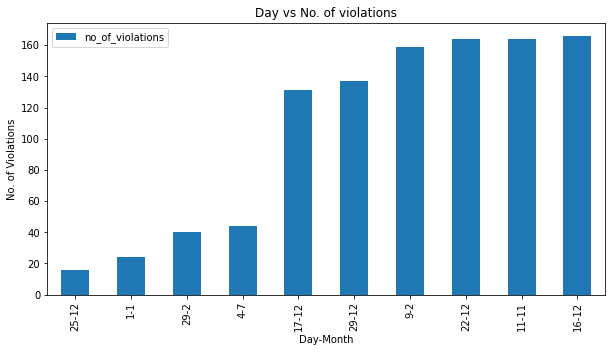

In [66]:
ma.holidays(spark)

# Timing evaluation

In [67]:
def execute_all(time_eval_df):
    ba.violation_frequencey(time_eval_df, False)
    ba.violations_by_bodytype(time_eval_df, False)
    ba.violations_by_make(time_eval_df, False)
    pba.violating_precicts(time_eval_df, False)
    pba.issuing_precincts(time_eval_df, False)
    pba.violation_code_frequency_top3_precincts(time_eval_df, False)
    tba.three_most_common_voilations_in_6_time_bins (spark, False)
    tba.five_most_common_Voilations_with_times(spark, False)
    sba.reduction_in_violations(time_eval_df, False)
    sba.season_violation_frequencies(time_eval_df, False)
    sba.common_violations_season(time_eval_df, False)
    rba.yearly_revenue(time_eval_df, False)
    rba.highest_revenue(time_eval_df, False)
    ma.repeat_offenders(spark, False)
    ma.in_out_state(spark, False)
    ma.weekends(spark, False)
    ma.holidays(spark, False)

In [68]:
from timeit import timeit
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def get_execution_time():
  NY_schema = dp.get_schema(schema_columns, schema_types)

  entries = [15000, 100000, 1000000, 10000000]
  time_data = []
  for entry in entries:
      data_file = '../data/time_eval_sample'+ f'{int(entry)}'+'.csv'
      time_eval_df = spark.read.option("header", True).schema(NY_schema).csv(data_file)
      time_eval_df.createOrReplaceTempView("NYCPV")

      execution_time = timeit(lambda : execute_all(time_eval_df), number=1)
      time_data.append(execution_time)

  fig, ax = plt.subplots(figsize=(5,5))
  ax.set_title("Data Entries Vs Time(s)")
  ax.set_xlabel("Number of Data Entries")
  ax.set_ylabel("Time of execution(seconds)")

  x_data = output = [str(x) for x in entries]
  ax.bar(x_data, time_data, color=['cyan', 'green', 'yellow', 'blue'])

  fig.savefig('../output/entries_execution_time.png')

  time_pd = pd.DataFrame(time_data, columns = ['Exectuin Time'], index = entries)
  time_pd.index.name = 'Data processed'
  time_pd

# get_execution_time()

In [69]:
# spark.stop()